# HEALPix tutorial

This Jupyter notebook demonstrates how to use HEALPix from the Healpy package to show sky density maps. The general idea is to use a catalogue of stars and convert it to a HEALPix map where each pixel shows the number of stars per square degrees of the sky. The input will be two arrays of RA and DEC or galactic latitude and longitude of the stars/catalogue. The function will than output a HEALPix map which can be printed at using the inbuild projection functions.

The healpy version used : 1.15.0 from [Healpy website](https://healpy.readthedocs.io/en/latest/tutorial.html).

Authors notes: Instead of using Matplotlib for plotting sky regions or density regions, I would recommend using Healpy as Matplotlib does include $cos\delta$ errors.

In the function convert the input to galactic latitude l and longitude b to spherical system $\varphi$ and $\theta$.

$-\pi \leqslant \varphi \leqslant \pi$  &  $0\leqslant \theta \leqslant \pi$.

Use these values of to create healpix indices from ang2pix function. And create a healpix map!

Author ~ Akash V.

In [1]:
#import required libraries
import healpy as hp
import numpy as np
from astropy.coordinates import SkyCoord

#define the function to be used
def cat_to_hpx(lon, lat, nside, radec=True):
    
    """
    Converts a catalogue to a HEALPix map of number density i.e. 
    Number of stars per square degrees of sky.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. 
        If radec=True, assume input is in the icrs system,
        Otherwise assume input is galactic latitude and longitude.


    nside : int
        HEALPix nside of the target map, defines the number of pixels.

    radec : bool
        Switch between Ra/Dec and l/b (galactic) as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat
        
    # convert to theta, phi -> galactic longitude and colatitude in sphererical system
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    indx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[indx] = counts

    return hpx_map

## Example

Using the GCNS ([More info here](https://www.cosmos.esa.int/web/gaia/edr3-gcns)) sample to show how to plot a sky map

In [2]:
#import required libraries
from astropy.table import Table
from pylab import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
#import GCNS data file
gcns_table = Table.read('GCNS_cat_table1.fits')

#consider stars only within 100pc and with a GCNS pobability of > 0.4
mask =  (gcns_table['Plx'] > 10) & (gcns_table['GCNSprob'] > 0.4)

#impport the RA and DEC of sources and apply mask
RA_gcns = gcns_table['RAdeg'].data[mask]
DEC_gcns = gcns_table['DEdeg'].data[mask]

0.0 180.0 -180.0 180.0


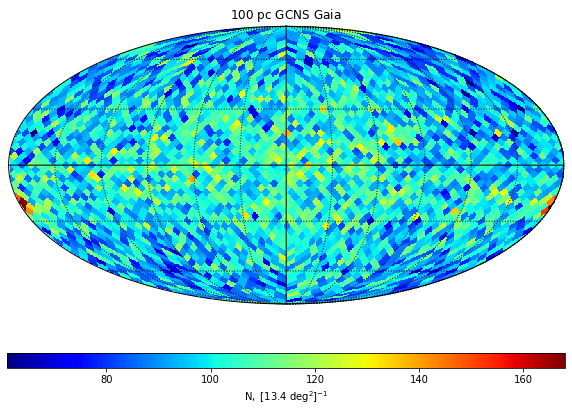

In [4]:
#input the nside, should be a number of 2**n
nside = 16

#call function to create Healpix map
hpx_map_gcns = cat_to_hpx(RA_gcns, DEC_gcns, nside=nside, radec=True)

#define a figure and size
f= plt.figure(figsize=(10,7))

#calculate the side of each pixel in square degrees
hpix_area = round(41253/len(np.arange(hp.nside2npix(nside),dtype=np.double)),1)   

#find minimum and maximum to normalise the colorbar
mmin, mmax = min((hpx_map_gcns)),max((hpx_map_gcns)) -40 #contribution from Hyades was strong, thus subtracted by random number (-40)

#add the desired 
cmap = cm.jet

#create a mollview projection from healpy and add custom colorbar and colormap
hp.mollview((hpx_map_gcns), hold=True, nest=False,cmap=cmap,min=mmin,max=mmax,notext=True,fig=1,
         cbar=False,title='$\mathrm{100 \ pc \ GCNS \ Gaia}$')

#add meridians and parallels
hp.graticule()

#create a colorbar axis
cax = f.add_axes([0.125, 0.1, 0.775, 0.03])

#create a colorbar and normalise it
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')

#add label to colorbar
cb.set_label(r'$\mathrm{ N, \ [}$'+str(hpix_area)+'$\mathrm{\ deg^2]^{-1}}$',fontsize=10)
cb.solids.set_edgecolor("face")
plt.show()

0.0 180.0 -180.0 180.0


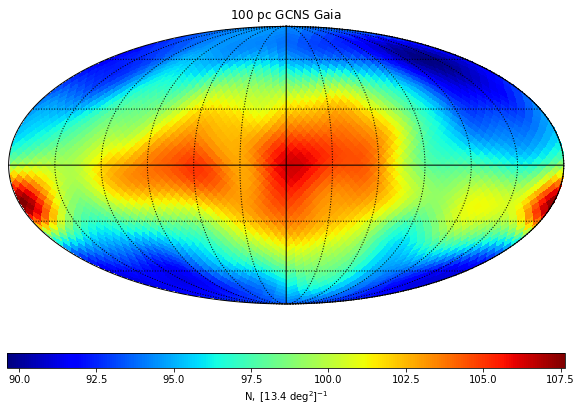

In [5]:
#smooth the healpix to see structure

#input the nside, should be a number of 2**n
nside = 16

#call function to create Healpix map
hpx_map_gcns = cat_to_hpx(RA_gcns, DEC_gcns, nside=nside, radec=True)

#smooth it using a gaussian of 0.2 radians
hpx_map_smooth = hp.sphtfunc.smoothing(hpx_map_gcns, sigma=0.2)

#define a figure and size
f= plt.figure(figsize=(10,7))

#calculate the side of each pixel in square degrees
hpix_area = round(41253/len(np.arange(hp.nside2npix(nside),dtype=np.double)),1)   

#find minimum and maximum to normalise the colorbar
mmin, mmax = min((hpx_map_smooth)),max((hpx_map_smooth))

#add the desired 
cmap = cm.jet

#create a mollview projection from healpy and add custom colorbar and colormap
hp.mollview((hpx_map_smooth), hold=True, nest=False,cmap=cmap,min=mmin,max=mmax,notext=True,fig=1,
         cbar=False,title='$\mathrm{100 \ pc \ GCNS \ Gaia}$')

#add meridians and parallels
hp.graticule()

#create a colorbar axis
cax = f.add_axes([0.125, 0.1, 0.775, 0.03])

#create a colorbar and normalise it
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')

#add label to colorbar
cb.set_label(r'$\mathrm{ N, \ [}$'+str(hpix_area)+'$\mathrm{\ deg^2]^{-1}}$',fontsize=10)
cb.solids.set_edgecolor("face")
plt.show()

Note: We can see the structure of the galactic disc at 100 pc, the hotspot at the lower right and left side is the contribution from the Hyades star cluster located at 47pc.